<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Transfer_Learning_Tuning_Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,re,time,json
import PIL.Image ,PIL.ImageFont , PIL.ImageDraw

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import  matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [2]:
BATCH_SZIE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
#@title Visualization Utilities[RUN ME]

plt.rc('image',cmap = 'gray')
plt.rc('grid',linewidth = 0)
plt.rc('xtick',top =False , bottom  = False , labelsize = 'large')
plt.rc('ytick' , left = False , right = False , labelsize = 'large')
plt.rc('axes' , facecolor = 'F8F8F8', titlesize = 'large' , edgecolor = 'white')
plt.rc('text',color = 'a8151a')
plt.rc('figure',facecolor = 'F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__) , "mpl-data/fonts/ttf")

def display_images(digits,predictions,labels,title):
    n = 10
    indexes = np.random.choice(len(predictions),size = n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize = (20,4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1,10,i+1)
        class_index  = n_predictions[i]

        plt.xlabel(classes[class_index])
        plt.yticks([])
        plt.xticks([])
        plt.imshow(n_digits[i])

def plot_metrics(metric_name , title , ylim  = 5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name] , color= 'blue' , label = metric_name)
    plt.plot(history.histroy['val_' + metric_name] , color = 'green',label = 'val_' + metric_name)

In [4]:
(training_images,training_labels) , (validation_images , validation_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


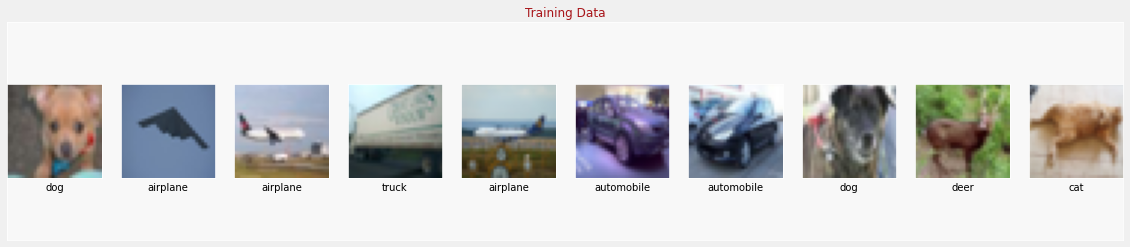

In [6]:
display_images(training_images,training_labels,training_labels , "Training Data")

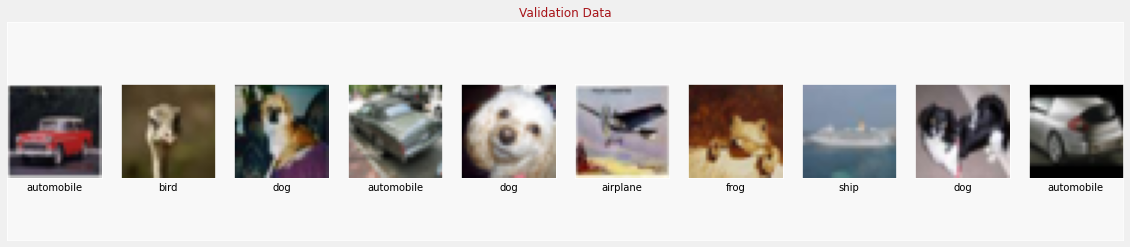

In [7]:
display_images(validation_images,validation_labels,validation_labels , "Validation Data")

In [8]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims

In [10]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [19]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape = (224,224,3),
                                                              include_top = False,
                                                              weights = 'imagenet')(inputs)
    return feature_extractor
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,activation = 'relu')(x)
    x = tf.keras.layers.Dense(512 , activation='relu')(x)
    x = tf.keras.layers.Dense(10,activation = 'softmax' , name = 'classification')(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size = (7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)

    classification_output = classifier(resnet_feature_extractor)

    return classification_output                                      

In [21]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape = (32,32,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs = inputs , outputs = classification_output)
    model.compile(optimizer = 'SGD',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

model = define_compile_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800

In [24]:
epochs = 1
history = model.fit(train_X,training_labels,epochs = epochs, validation_data = (valid_X , validation_labels) , workers=10, use_multiprocessing=True)

  34/1563 [..............................] - ETA: 16:59 - loss: 0.0967 - accuracy: 0.9678

KeyboardInterrupt: ignored

In [ ]:
loss , accuracy = model.evaluate(valid_X , validation_labels , batch_size = batch_size )

In [ ]:
plot_metrics ('loss','Loss')


In [ ]:
plot_metrics('accuracy','Accuracy')

In [ ]:
probabilities = model.predict(valid_X,batch_size = 64)
probabilities = np.argmax(probabilites , axis = 1)
display_images(validation_images , probabilities , validation_labels , "Bad predictions indicated in red.")